In [21]:
# Importations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns 
# Configuration pour visualisations
# plt.style.use('sns')
# sns.set_palette('husl')

# Charger le dataset
df = pd.read_csv('C:/Users/Infinix/Desktop/Projet fil rouge/data/processed/medical_dataset_ml.csv')  # Utilisez sep='\t' si c'est tabulé
print("Aperçu du dataset :")
print(df.head())
print(f"Taille du dataset : {df.shape}")
print("Types de données :")
print(df.dtypes)

Aperçu du dataset :
   Patient_ID                                       All_Symptoms  \
0           1  itching, skin_rash, nodal_skin_eruptions, disc...   
1           2  skin_rash, nodal_skin_eruptions, dischromic _p...   
2           3  itching, nodal_skin_eruptions, dischromic _pat...   
3           4         itching, skin_rash, dischromic _patches, 5   
4           5        itching, skin_rash, nodal_skin_eruptions, 5   

   Symptom_Count  Severity_Score           Disease  
0              6        2.666667  Fungal infection  
1              5        3.500000  Fungal infection  
2              5        2.500000  Fungal infection  
3              5        2.000000  Fungal infection  
4              5        2.666667  Fungal infection  
Taille du dataset : (5148, 5)
Types de données :
Patient_ID          int64
All_Symptoms       object
Symptom_Count       int64
Severity_Score    float64
Disease            object
dtype: object


Statistiques descriptives :
        Patient_ID  Symptom_Count  Severity_Score
count  5148.000000    5148.000000     5148.000000
mean   2574.500000       9.179293        4.096419
std    1486.243923       3.731349        0.715643
min       1.000000       3.000000        1.900000
25%    1287.750000       6.000000        3.727273
50%    2574.500000       8.000000        4.100000
75%    3861.250000      12.000000        4.600000
max    5148.000000      19.000000        6.000000
Valeurs manquantes :
Patient_ID        0
All_Symptoms      0
Symptom_Count     0
Severity_Score    0
Disease           0
dtype: int64


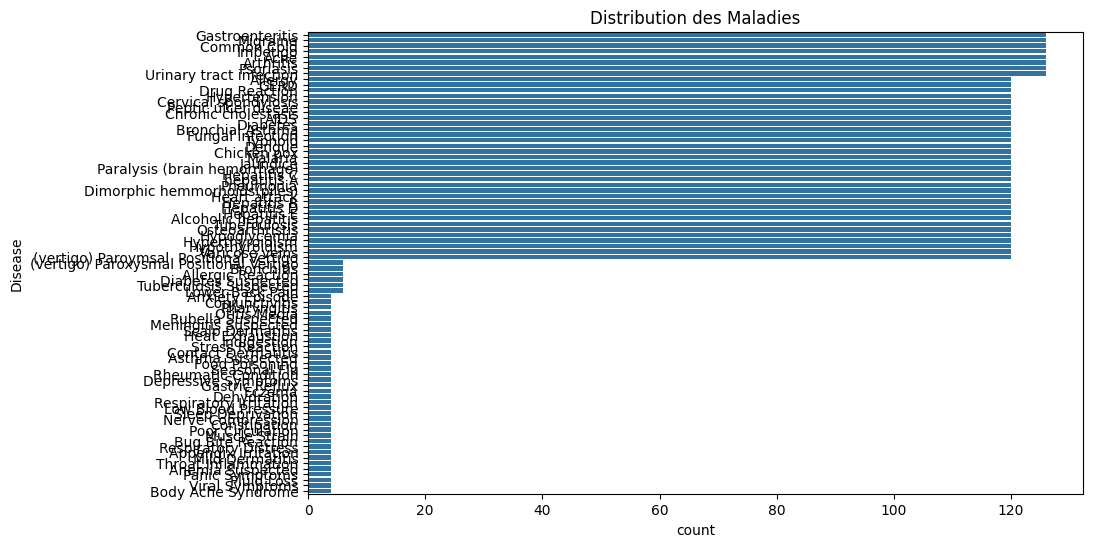

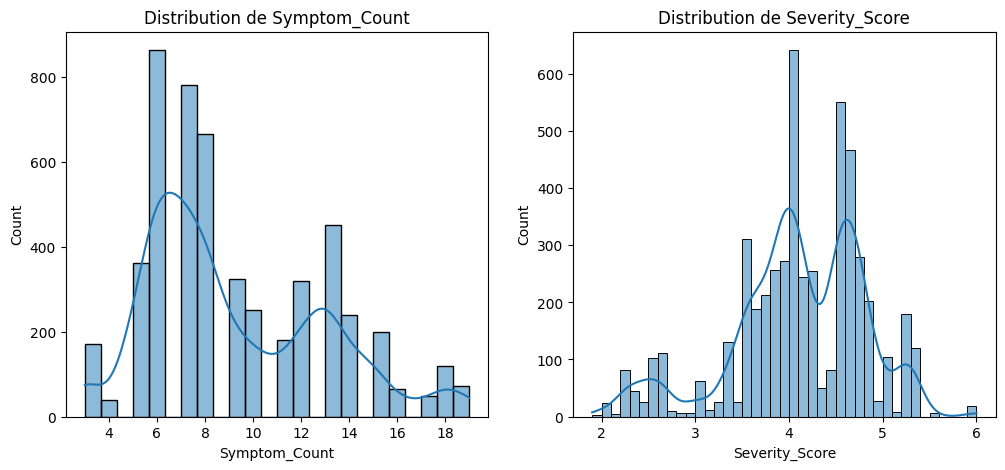

Symptômes les plus fréquents :
fatigue              1975
vomiting             1927
high_fever           1365
nausea               1164
headache             1156
loss_of_appetite     1152
abdominal_pain       1043
yellowish_skin        912
6                     863
yellowing_of_eyes     816
Name: count, dtype: int64


In [22]:
# Statistiques descriptives
print("Statistiques descriptives :")
print(df.describe())

# Vérifier les valeurs manquantes
print("Valeurs manquantes :")
print(df.isnull().sum())

# Distribution des maladies (target)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Disease', order=df['Disease'].value_counts().index)
plt.title('Distribution des Maladies')
plt.show()

# Distribution de Symptom_Count et Severity_Score
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Symptom_Count'], ax=axes[0], kde=True)
axes[0].set_title('Distribution de Symptom_Count')
sns.histplot(df['Severity_Score'], ax=axes[1], kde=True)
axes[1].set_title('Distribution de Severity_Score')
plt.show()

# Exemple de symptômes fréquents (si besoin, analysez All_Symptoms)
symptoms_list = df['All_Symptoms'].str.split(', ')
all_symptoms = [symptom for sublist in symptoms_list for symptom in sublist]
unique_symptoms = pd.Series(all_symptoms).value_counts()
print("Symptômes les plus fréquents :")
print(unique_symptoms.head(10))

In [23]:
# Encoder All_Symptoms avec MultiLabelBinarizer
mlb = MultiLabelBinarizer()
symptoms_encoded = mlb.fit_transform(df['All_Symptoms'].str.split(', '))
symptoms_df = pd.DataFrame(symptoms_encoded, columns=mlb.classes_)

# Combiner avec les autres features
features = pd.concat([df[['Symptom_Count', 'Severity_Score']], symptoms_df], axis=1)
target = df['Disease']

# Normaliser les features numériques
scaler = StandardScaler()
features[['Symptom_Count', 'Severity_Score']] = scaler.fit_transform(features[['Symptom_Count', 'Severity_Score']])
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)  # target est df['Disease']

# Séparation train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded)
print(f"Taille train : {X_train.shape}, Test : {X_test.shape}")
print("Mapping des classes (exemples) :")
for i, class_name in enumerate(label_encoder.classes_[:5]):  # Affiche les 5 premiers
    print(f"{i}: {class_name}")

Taille train : (4118, 304), Test : (1030, 304)
Mapping des classes (exemples) :
0: (vertigo) Paroxysmal Positional Vertigo
1: (vertigo) Paroymsal  Positional Vertigo
2: AIDS
3: Acne
4: Alcoholic hepatitis


Précision sur test : 96.80%
Rapport de classification :
                                         precision    recall  f1-score   support

(vertigo) Paroxysmal Positional Vertigo       0.00      0.00      0.00         1
(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        25
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                      Allergic Reaction       0.00      0.00      0.00         1
                                Allergy       1.00      1.00      1.00        24
                       Anemia Suspected       0.00      0.00      0.00         1
                        Anxiety Episode       0.00      0.00      0.00         1
                    Appendix Irritation       0.00      0.00      0.00         1
                              Arthritis       1.00  

c:\Users\Infinix\Desktop\Projet fil rouge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Infinix\Desktop\Projet fil rouge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Infinix\Desktop\Projet fil rouge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

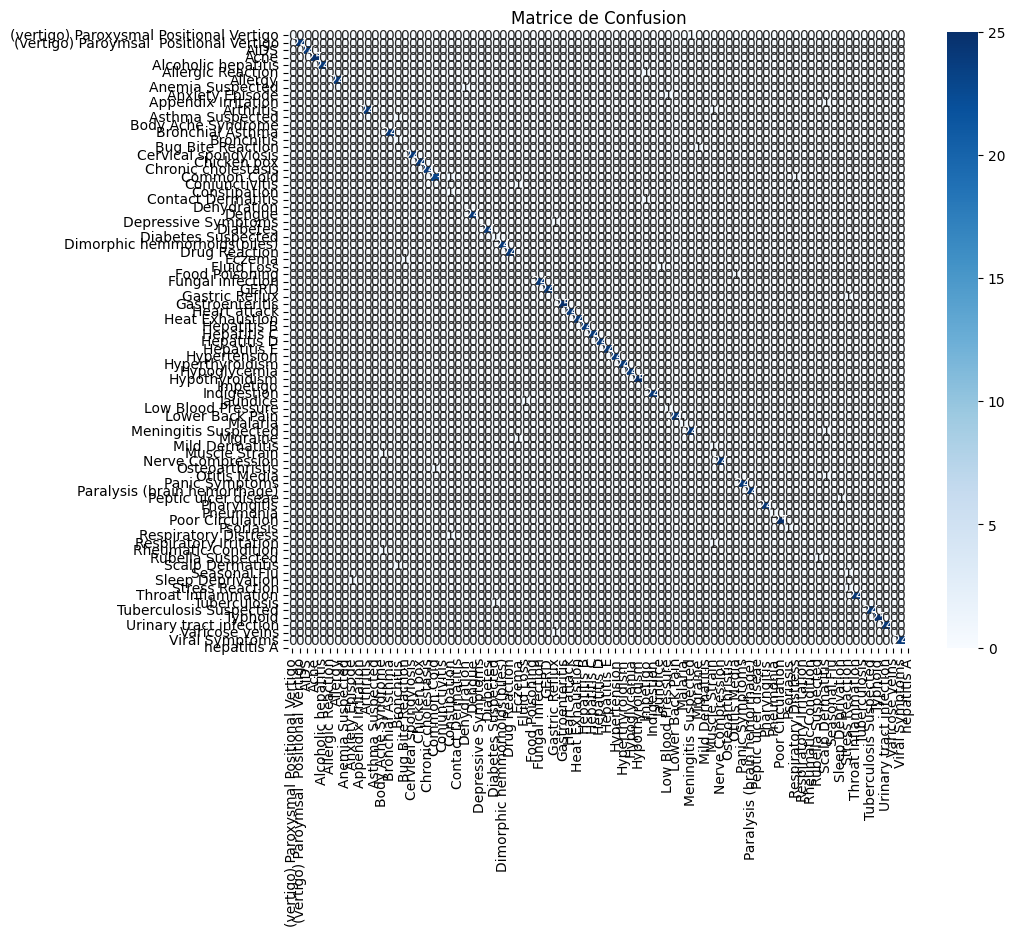

In [24]:
# Modèle XGBoost (corrigé)
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Prédictions sur test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision sur test : {accuracy * 100:.2f}%")

# Rapport de classification (décodé pour lisibilité)
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print("Rapport de classification :")
print(classification_report(y_test_decoded, y_pred_decoded))

# Matrice de confusion (avec noms décodés)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_decoded, y_pred_decoded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matrice de Confusion')
plt.show()

In [25]:
# Explainer SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Résumé des valeurs SHAP (inchangé)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
plt.title('Importance des Features (SHAP)')
plt.show()

# Exemple d'explication (corrigé avec débogage et conversion)
sample_idx = 0
predicted_disease = label_encoder.inverse_transform([y_pred[sample_idx]])[0]

# Prints de débogage (ajoutez-les pour vérifier)
print("Shape of X_test.iloc[sample_idx]:", X_test.iloc[sample_idx].shape)
print("Shape of shap_values[y_pred[sample_idx]][sample_idx]:", shap_values[y_pred[sample_idx]][sample_idx].shape)
print("y_pred[sample_idx]:", y_pred[sample_idx])
print("len(label_encoder.classes_):", len(label_encoder.classes_))
print("explainer.expected_value shape:", np.array(explainer.expected_value).shape)

# Convertir features en array pour éviter les erreurs de type
features_sample = X_test.iloc[sample_idx].values  # Conversion en array NumPy

# Force plot pour la classe prédite (utilisez shap.plots.force si force_plot est deprecated)
try:
    shap.force_plot(
        explainer.expected_value[y_pred[sample_idx]],  # Base value pour la classe
        shap_values[y_pred[sample_idx]][sample_idx],   # SHAP values pour l'échantillon et la classe
        features_sample,                               # Features en array
        feature_names=X_test.columns,                   # Noms des features
        matplotlib=True
    )
    plt.title(f'Explication pour l\'échantillon {sample_idx} (Prédit : {predicted_disease})')
    plt.show()
except Exception as e:
    print(f"Erreur dans force_plot : {e}")
    print("Essayez shap.plots.force ou changez sample_idx.")
    # Alternative : Utilisez shap.plots.force (pour SHAP récent)
    # shap.plots.force(explainer.expected_value[y_pred[sample_idx]], shap_values[y_pred[sample_idx]][sample_idx], features_sample, feature_names=X_test.columns)


ValueError: kth(=25988960) out of bounds (25988960)

In [ ]:
# import joblib
# joblib.dump(model, 'models/xgb_model.pkl')
# joblib.dump(scaler, 'models/scaler.pkl')
# joblib.dump(mlb, 'models/mlb.pkl')
# joblib.dump(label_encoder, 'models/label_encoder.pkl')  # Ajouté pour décodage en API
# print("Modèle et encodeurs sauvegardés. Prêt pour l'API !")
# print(f"Précision finale : {accuracy * 100:.2f}% - Objectif : >95%")

FileNotFoundError: [Errno 2] No such file or directory: 'models/xgb_model.pkl'